In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate, Reshape, Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from code.modelhelper import *

c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dty

In [2]:
NCLASS = 2
BATCH_SIZE = 150
EPOCHS = 300

In [3]:
m2 = load_model("models/dl/m2.h5")
m3 = load_model("models/dl/m3.h5")

W0831 15:44:38.789182  5384 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
x_char = np.load("data/xy/x_char_onehot_45_15.npz")["arr_0"]
x_word = np.load("data/xy/x_word_45_15.npy")
y = np.load("data/xy/y_onehot_45_15.npy")

In [5]:
xc_train, xc_test, y_train, y_test = train_test_split(
    x_char,
    y,
    test_size=0.2,
    random_state=11
)

xw_train, xw_test, y_train, y_test = train_test_split(
    x_word,
    y,
    test_size=0.2,
    random_state=11
)

# Models 2, 3 Fusion

In [5]:
for layer in m2.layers:
    layer.trainable = False
    
for layer in m3.layers:
    layer.trainable = False

In [6]:
model_input = concatenate(
    [
        m2.get_layer("m2_gru_2").output,
        m3.get_layer("m3_lstm").output,
    ]
)

H = Reshape((256+32, 1), name="fusion_reshape")(model_input)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_1"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_1")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_2"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_2")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_3"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_3")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_4"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_4")(H)

H = Flatten(name="fusion_flatten")(H)
H = Dense(256, activation='tanh', name="fusion_dense_1")(H)
H = Dense(64, activation='tanh', name="fusion_dense_2")(H)
model_output = Dense(NCLASS, activation='softmax', name="fusion_output")(H)

model = Model(inputs=[m2.input, m3.input], outputs=model_output)
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m2_input (InputLayer)           [(None, 13900)]      0                                            
__________________________________________________________________________________________________
m2_reshape (Reshape)            (None, 100, 139, 1)  0           m2_input[0][0]                   
__________________________________________________________________________________________________
m2_timedistributed_1 (TimeDistr (None, 100, 139, 20) 60          m2_reshape[0][0]                 
__________________________________________________________________________________________________
m2_timedistributed_2 (TimeDistr (None, 100, 69, 20)  0           m2_timedistributed_1[0][0]       
______________________________________________________________________________________________

# Training

In [8]:
history = model.fit(
    [xc_train, xw_train],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=([xc_test, xw_test], y_test),
    callbacks=[es]
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/300
48000/48000 - 88s - loss: 0.0505 - accuracy: 0.9817 - val_loss: 0.0634 - val_accuracy: 0.9790
Epoch 2/300
48000/48000 - 81s - loss: 0.0426 - accuracy: 0.9865 - val_loss: 0.0590 - val_accuracy: 0.9798
Epoch 3/300
48000/48000 - 81s - loss: 0.0433 - accuracy: 0.9858 - val_loss: 0.0583 - val_accuracy: 0.9800
Epoch 4/300
48000/48000 - 81s - loss: 0.0428 - accuracy: 0.9865 - val_loss: 0.0586 - val_accuracy: 0.9798
Epoch 5/300
48000/48000 - 81s - loss: 0.0411 - accuracy: 0.9869 - val_loss: 0.0609 - val_accuracy: 0.9802
Epoch 6/300
48000/48000 - 82s - loss: 0.0416 - accuracy: 0.9873 - val_loss: 0.0618 - val_accuracy: 0.9793
Epoch 7/300
48000/48000 - 81s - loss: 0.0420 - accuracy: 0.9868 - val_loss: 0.0587 - val_accuracy: 0.9793
Epoch 8/300
48000/48000 - 81s - loss: 0.0415 - accuracy: 0.9873 - val_loss: 0.0668 - val_accuracy: 0.9800


In [9]:
# score = model.evaluate([xf_test, xc_test, xw_test], y_test, verbose=0)
score = model.evaluate([xc_test, xw_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# y_pred_model = model.predict([xf_test, xc_test, xw_test])
y_pred_model = model.predict([xc_test, xw_test])
y_pred = to_bin(y_pred_model)
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.05825250358382861
Test accuracy: 0.98
Test recall: 0.9452517742480567
[[8963   78]
 [ 162 2797]]


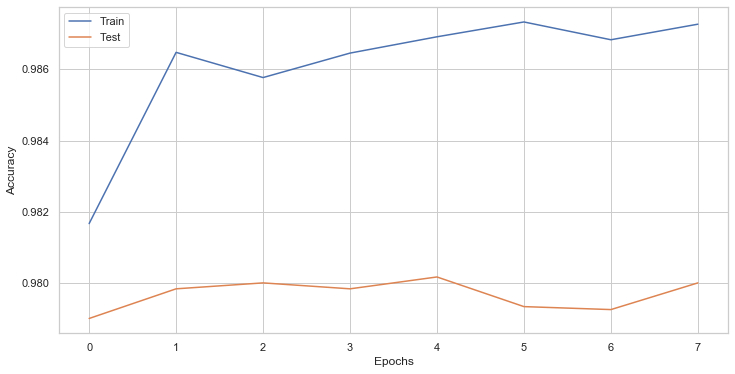

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [11]:
model.save("models/dl/fusion_23.h5")

# K-fold CV

In [7]:
model_params = {
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "es": es,
}

In [8]:
scores = kfold_multi_input(model, model_params, [x_char, x_word], y, cv=10)

Starting 10-fold cross validation:
    Validation 01 of 10 ... done [602.71s]
    Validation 02 of 10 ... done [704.12s]
    Validation 03 of 10 ... done [697.13s]
    Validation 04 of 10 ... done [1047.81s]
    Validation 05 of 10 ... done [1071.74s]
    Validation 06 of 10 ... done [719.28s]
    Validation 07 of 10 ... done [720.96s]
    Validation 08 of 10 ... done [1417.98s]
    Validation 09 of 10 ... done [1073.95s]
    Validation 10 of 10 ... done [1527.49s]


In [9]:
arr = scores_dict_to_array(scores)
arr

array([[0.981     , 0.98033333, 0.9895    , 0.98683333, 0.98933333,
        0.9865    , 0.98966667, 0.98933333, 0.99116667, 0.98816667],
       [0.97682584, 0.97304768, 0.9831309 , 0.98702186, 0.98771331,
        0.97693351, 0.99395973, 0.98459478, 0.98900388, 0.98728814],
       [0.94497283, 0.9468729 , 0.97458194, 0.96013289, 0.96918955,
        0.96839274, 0.9654498 , 0.97286565, 0.97699681, 0.96347347],
       [0.00728799, 0.0086417 , 0.00554939, 0.00422692, 0.00399379,
        0.00753379, 0.00201523, 0.00512364, 0.00383315, 0.00395691]])

In [10]:
np.save("cv/fusion_23_cv.npy", arr)